In [1]:
import tensorflow as tf
import pandas            as pd
import tensorflow        as tf  
import numpy             as np
import matplotlib.pyplot as plt
# 支持中文
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

from numpy                 import array
from sklearn               import metrics
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models          import Sequential
from tensorflow.keras.layers          import Dense,LSTM,Bidirectional

from numpy.random   import seed



In [91]:
# 确保结果尽可能重现

seed(1)
tf.random.set_seed(1)

# 设置相关参数
n_timestamp  = 5    # 时间戳
n_epochs     = 30    # 训练轮数
# ====================================
#      选择模型：
#            1: 单层 LSTM
#            2: 多层 LSTM
#            3: 双向 LSTM
# ====================================
model_type = 1

In [3]:
# 导入tushare
import tushare as ts

In [42]:
#pro=ts.get_hist_data('603722')
help(ts.pro_api)

Help on function pro_api in module tushare.pro.data_pro:

pro_api(token='', timeout=30)
    初始化pro API,第一次可以通过ts.set_token('your token')来记录自己的token凭证，临时token可以通过本参数传入



In [4]:

# 初始化pro接口
pro = ts.pro_api('84a7d42ba53be1e345b15650d19116113087ad5440320b4c6b7b6c67')

# 拉取数据
data = pro.daily(**{
    "ts_code": '603722.sh',
    "trade_date": "",
    "start_date": "2000-1-1",
    "end_date": "",
    "offset": "",
    "limit": ""
}, fields=[
    "trade_date",
    "open",
    "close",
    "high",
    "low",
    "vol",
    "ts_code"
])


In [7]:
print(data)
data.to_csv("stock603722.csv")

       ts_code trade_date   open   high    low  close      vol
0    603722.SH   20211029  42.89  43.88  42.59  43.83  5095.62
1    603722.SH   20211028  44.00  44.78  42.38  42.89  7276.00
2    603722.SH   20211027  45.45  45.52  43.50  44.57  7118.00
3    603722.SH   20211026  44.51  46.23  44.14  45.53  8511.00
4    603722.SH   20211025  44.41  44.95  43.57  44.73  4819.25
..         ...        ...    ...    ...    ...    ...      ...
969  603722.SH   20171031  23.71  23.71  23.71  23.71   135.97
970  603722.SH   20171030  21.55  21.55  21.55  21.55   100.00
971  603722.SH   20171027  19.59  19.59  19.59  19.59    40.90
972  603722.SH   20171026  17.81  17.81  17.81  17.81    32.35
973  603722.SH   20171025  13.49  16.19  13.49  16.19    33.00

[974 rows x 7 columns]


In [9]:
data=pd.read_csv("./stock603722.csv",parse_dates=["trade_date"],index_col="trade_date")[["open","high","low","close"]]
# data=pd.read_csv("./stock688333.csv",parse_dates=["trade_date"])[["trade_date","open","high","low","close","vol"]]
data

,open,high,low,close
trade_date,,,,
2021-10-29,42.89,43.88,42.59,43.83
2021-10-28,44.00,44.78,42.38,42.89
2021-10-27,45.45,45.52,43.50,44.57
2021-10-26,44.51,46.23,44.14,45.53
2021-10-25,44.41,44.95,43.57,44.73
...,...,...,...,...
2017-10-31,23.71,23.71,23.71,23.71
2017-10-30,21.55,21.55,21.55,21.55
2017-10-27,19.59,19.59,19.59,19.59


In [ ]:
# 获取股价数据
import pandas as pd
import numpy as np
import akshare as ak

pingan = ak.stock_zh_a_daily(symbol="sh601318", adjust="qfq")
df3 = pingan.reset_index().iloc[-30:,:6]  #取过去30天数据
df3 = df3.dropna(how='any').reset_index(drop=True) #去除空值且从零开始编号索引
df3 = df3.sort_values(by='date', ascending=True)
print(df3.info())

# 均线数据
df3['5'] = df3.close.rolling(5).mean()
df3['10'] = df3.close.rolling(10).mean()

df3.tail()

In [ ]:
import matplotlib
matplotlib.style.use('ggplot') #用于调整图标样式，可选
import matplotlib.pyplot as plt
from mplfinance.original_flavor import candlestick2_ohlc
from matplotlib.ticker import FormatStrFormatter

fig, ax = plt.subplots(1, 1, figsize=(8,3), dpi=200)

candlestick2_ohlc(ax,
                  opens = df3[ 'open'].values,
                highs = df3['high'].values,
                lows = df3[ 'low'].values,
                closes = df3['close'].values,
                  width=0.5, colorup="r",colordown="g")

# 显示最高点和最低点
ax.text( df3.high.idxmax(), df3.high.max(),   s =df3.high.max(), fontsize=8)
ax.text( df3.high.idxmin(), df3.high.min()-2, s = df3.high.min(), fontsize=8)

ax.set_facecolor("white")
ax.set_title("中国平安")

# 画均线
plt.plot(df3['5'].values, alpha = 0.5, label='MA5')
plt.plot(df3['10'].values, alpha = 0.5, label='MA10')

ax.legend(facecolor='white', edgecolor='white', fontsize=6)

# 修改x轴坐标
plt.xticks(ticks =  np.arange(0,len(df3)), labels = df3.date.dt.strftime('%Y-%m-%d').to_numpy() )
plt.xticks(rotation=90, size=8)

# 修改y轴坐标
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

plt.show()

In [47]:
#from matplotlib.dates  import date2num
#data['date']=date2num(data.index.to_pydatetime())
#data=data.sort_values(by="date",ascending=True)
data

,open,high,low,close
trade_date,,,,
2021-10-26,21.75,22.19,21.18,21.24
2021-10-25,20.08,21.71,20.08,21.68
2021-10-22,21.83,22.04,20.73,20.92
2021-10-21,21.62,22.91,21.20,22.39
2021-10-20,20.71,21.93,20.11,21.61
...,...,...,...,...
2000-12-28,16.50,16.68,16.31,16.31
2000-12-27,16.47,16.72,16.31,16.50
2000-12-26,16.06,16.58,16.01,16.42


In [10]:
# 获取股价数据
import pandas as pd
import numpy as np

df3 = data.reset_index().iloc[:,:]  #取过去30天数据
df3 = df3.dropna(how='any').reset_index(drop=True) #去除空值且从零开始编号索引
print(df3)
df3 = df3.sort_values(by='trade_date', ascending=True)
print(df3.info())

# 均线数据
df3['5'] = df3.close.rolling(5).mean()
df3['10'] = df3.close.rolling(10).mean()
df3['30']=df3.close.rolling(30).mean()

df3

    trade_date   open   high    low  close
0   2021-10-29  42.89  43.88  42.59  43.83
1   2021-10-28  44.00  44.78  42.38  42.89
2   2021-10-27  45.45  45.52  43.50  44.57
3   2021-10-26  44.51  46.23  44.14  45.53
4   2021-10-25  44.41  44.95  43.57  44.73
..         ...    ...    ...    ...    ...
969 2017-10-31  23.71  23.71  23.71  23.71
970 2017-10-30  21.55  21.55  21.55  21.55
971 2017-10-27  19.59  19.59  19.59  19.59
972 2017-10-26  17.81  17.81  17.81  17.81
973 2017-10-25  13.49  16.19  13.49  16.19

[974 rows x 5 columns]
<class 'pandas.core.frame.DataFrame'>
Int64Index: 974 entries, 973 to 0
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   trade_date  974 non-null    datetime64[ns]
 1   open        974 non-null    float64       
 2   high        974 non-null    float64       
 3   low         974 non-null    float64       
 4   close       974 non-null    float64       
dtypes: datetime64[n

,trade_date,open,high,low,close,5,10,30
973,2017-10-25,13.49,16.19,13.49,16.19,NaN,NaN,NaN
972,2017-10-26,17.81,17.81,17.81,17.81,NaN,NaN,NaN
971,2017-10-27,19.59,19.59,19.59,19.59,NaN,NaN,NaN
970,2017-10-30,21.55,21.55,21.55,21.55,NaN,NaN,NaN
969,2017-10-31,23.71,23.71,23.71,23.71,19.770,NaN,NaN
...,...,...,...,...,...,...,...,...
4,2021-10-25,44.41,44.95,43.57,44.73,44.864,44.625,47.564000
3,2021-10-26,44.51,46.23,44.14,45.53,44.954,44.884,47.475333
2,2021-10-27,45.45,45.52,43.50,44.57,44.808,45.018,47.328667
1,2021-10-28,44.00,44.78,42.38,42.89,44.426,44.869,47.045000


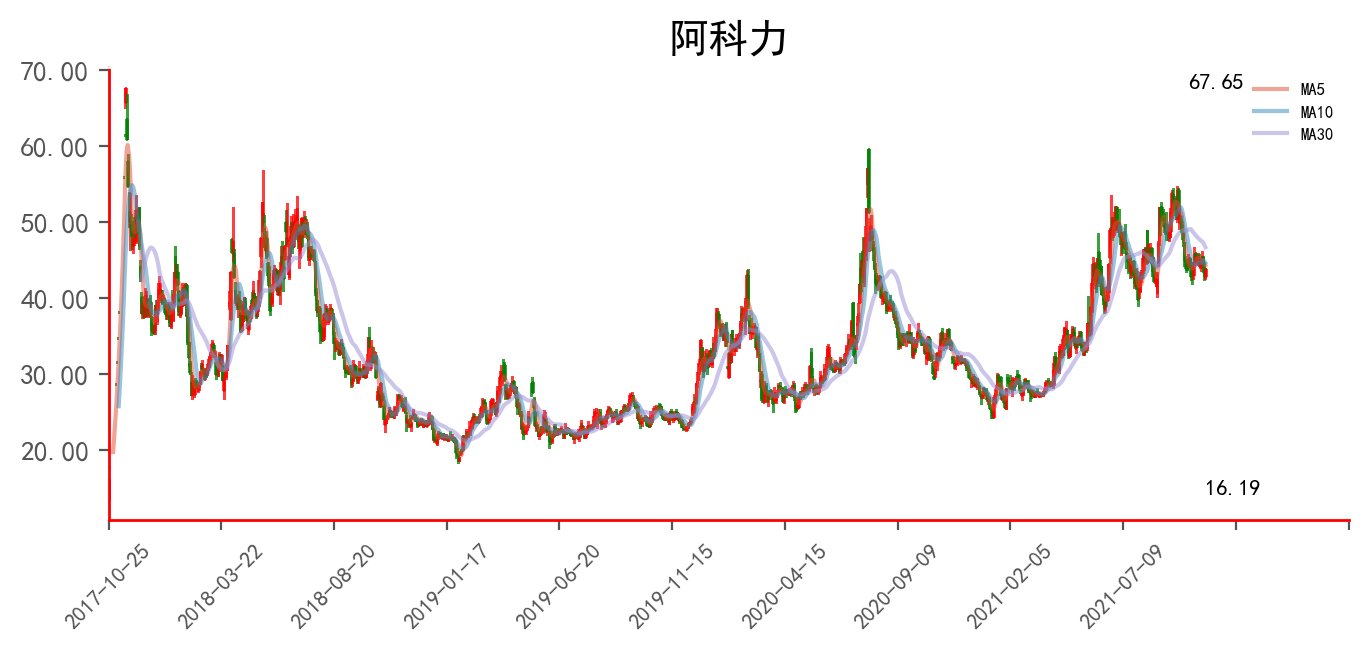

In [60]:
import matplotlib
matplotlib.style.use('ggplot') #用于调整图标样式，可选
import matplotlib.pyplot as plt
from mplfinance.original_flavor import candlestick2_ohlc
from matplotlib.ticker import FormatStrFormatter

fig, ax = plt.subplots(1, 1, figsize=(8,3), dpi=200)

candlestick2_ohlc(ax,
                  opens = df3[ 'open'].values,
                highs = df3['high'].values,
                lows = df3[ 'low'].values,
                closes = df3['close'].values,
                  width=0.5, colorup="r",colordown="g")

# 显示最高点和最低点
ax.text( df3.high.idxmax(), df3.high.max(),   s =df3.high.max(), fontsize=8)
ax.text( df3.high.idxmin(), df3.high.min()-2, s = df3.high.min(), fontsize=8)

ax.set_facecolor("white")
ax.set_title("阿科力")

# 画均线
plt.plot(df3['5'].values, alpha = 0.5, label='MA5')
plt.plot(df3['10'].values, alpha = 0.5, label='MA10')
plt.plot(df3['30'].values,alpha=0.5, label='MA30')

ax.legend(facecolor='white', edgecolor='white', fontsize=6)

# 修改x轴坐标
tempXticks=np.arange(0,len(df3))
#XticksData=data.asfreq("2M").dropna()
nameXticks =  df3.trade_date.dt.strftime('%Y-%m-%d').to_numpy()

plt.xticks(ticks =tempXticks , labels =nameXticks )
plt.xticks(rotation=45, size=8)
#修改X轴间隔
x_major_locator=plt.MultipleLocator(100)
ax.xaxis.set_major_locator(x_major_locator)
ax.spines['bottom'].set_color('red')
ax.spines['left'].set_color('red')
plt.xlim(0,1100)
# 修改y轴坐标
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

plt.show()

In [53]:

a=np.linspace(0,round(len(df3),0),10,dtype=int).tolist()
b=df3.trade_date.dt.strftime('%Y-%m-%d').to_numpy()
c=data.asfreq("2M").dropna()
#c.dropna().index
cc=c.index.strftime('%Y-%m-%d').to_numpy()
e=df3.trade_date.tolist()
#f=[e[i] for i in cc]
cc

array(['2017-10-31', '2018-02-28', '2018-08-31', '2018-10-31',
       '2019-02-28', '2019-04-30', '2019-10-31', '2019-12-31',
       '2020-04-30', '2020-06-30', '2020-08-31', '2020-12-31',
       '2021-04-30', '2021-06-30', '2021-08-31'], dtype=object)

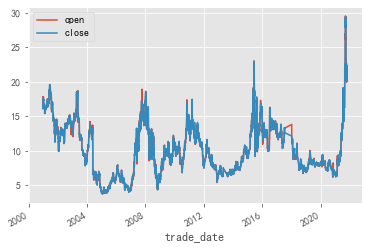

In [36]:
# data1=pd.DataFrame(data,columns=["trade_date","close"])
#data1=pd.DataFrame(data,columns=["close"])
data1=data.iloc[::-1]
data1["open"].plot(label="open")
data1["close"].plot(label="close")
plt.legend()
plt.show()


In [37]:
ddd=[]
for item in data1.items():
    ddd.append(item)
ind=ddd[0][1].values
da1=ddd[1][1].values
index1=[]
data2=[]
for item in ind:
    index1.append(item)
index1.reverse()
for item in da1:
    data2.append(item)
data2.reverse()
data1={'trade_date':index1,'close':data2}
stockdata=pd.DataFrame(data1)

stockdata.items    

<bound method DataFrame.items of       trade_date  close
0          21.75  22.19
1          20.08  21.71
2          21.83  22.04
3          21.62  22.91
4          20.71  21.93
...          ...    ...
4771       16.50  16.68
4772       16.47  16.72
4773       16.06  16.58
4774       16.20  16.35
4775       17.78  17.88

[4776 rows x 2 columns]>

In [23]:
df3.iloc[0:3000,1:3].values[:,1]

array([19.15, 18.92, 16.92, 17.47, 17.95, 15.89, 15.34, 15.04, 15.45,
       16.34, 17.14, 18.1 , 17.4 , 18.19, 18.32, 18.25, 17.27, 16.94,
       16.64, 17.08, 17.15, 17.87, 18.23, 19.88, 21.87, 23.56, 23.17,
       22.67, 21.59, 22.44, 21.88, 23.43, 25.77, 27.74, 27.51, 29.39,
       29.55, 29.55, 30.5 , 31.  , 29.84, 29.66, 27.47, 27.  , 24.85,
       23.58, 22.63, 22.88, 22.  , 21.79, 20.86, 20.52, 20.5 , 20.63,
       22.  , 21.93, 22.91, 22.04, 21.71, 22.19])

In [64]:
from matplotlib.dates  import date2num
date2num(df3.trade_date.values)
df3['date']=date2num(df3.trade_date.values)
#df3=df3.sort_values(by="date",ascending=True)

#df3=df3[['date','open', 'high', 'low', 'close']]
ind=np.arange(0,3000)
dataf1=df3[['date','open', 'high', 'low', 'close']]

In [65]:
dataf1.set_index("date")

,open,high,low,close
date,,,,
17464.0,13.49,16.19,13.49,16.19
17465.0,17.81,17.81,17.81,17.81
17466.0,19.59,19.59,19.59,19.59
17469.0,21.55,21.55,21.55,21.55
17470.0,23.71,23.71,23.71,23.71
...,...,...,...,...
18925.0,44.41,44.95,43.57,44.73
18926.0,44.51,46.23,44.14,45.53
18927.0,45.45,45.52,43.50,44.57


In [100]:
training_set = dataf1.iloc[0:512, 4:5].to_numpy()#要提取一列数据，否则会出错
test_set     = dataf1.iloc[973 - 300:, 4:5].to_numpy()
print(training_set)

[[16.19]
 [17.81]
 [19.59]
 [21.55]
 [23.71]
 [26.08]
 [28.69]
 [31.56]
 [34.72]
 [38.19]
 [42.01]
 [46.21]
 [50.83]
 [55.91]
 [61.5 ]
 [67.65]
 [60.89]
 [54.8 ]
 [50.15]
 [51.33]
 [48.74]
 [47.01]
 [47.8 ]
 [48.65]
 [51.57]
 [50.91]
 [51.65]
 [46.93]
 [42.24]
 [38.03]
 [39.14]
 [37.56]
 [40.25]
 [40.37]
 [37.84]
 [38.42]
 [39.34]
 [37.9 ]
 [35.86]
 [36.33]
 [35.53]
 [39.08]
 [38.32]
 [39.18]
 [41.27]
 [40.84]
 [41.06]
 [39.54]
 [40.21]
 [39.02]
 [38.09]
 [37.65]
 [38.47]
 [39.27]
 [36.83]
 [38.31]
 [38.97]
 [39.45]
 [43.4 ]
 [42.92]
 [44.06]
 [41.88]
 [38.34]
 [38.45]
 [39.44]
 [41.24]
 [39.41]
 [41.48]
 [41.92]
 [37.81]
 [34.3 ]
 [32.28]
 [30.29]
 [27.26]
 [28.75]
 [28.98]
 [28.09]
 [28.89]
 [28.27]
 [27.91]
 [28.83]
 [30.27]
 [30.89]
 [31.37]
 [30.03]
 [30.61]
 [29.74]
 [30.79]
 [31.39]
 [32.33]
 [32.88]
 [33.32]
 [34.08]
 [32.36]
 [32.6 ]
 [30.09]
 [30.08]
 [30.98]
 [32.71]
 [31.46]
 [32.53]
 [29.28]
 [29.62]
 [30.23]
 [30.78]
 [33.86]
 [37.25]
 [39.45]
 [43.4 ]
 [47.74]
 [47.57]
 

In [101]:
#将数据归一化，范围是0到1
sc  = MinMaxScaler(feature_range=(0, 1))
training_set_scaled = sc.fit_transform(training_set)
testing_set_scaled  = sc.transform(test_set) 


In [102]:
# 取前 n_timestamp 天的数据为 X；n_timestamp+1天数据为 Y。
def data_split(sequence, n_timestamp):
    X = []
    y = []
    for i in range(len(sequence)):
        end_ix = i + n_timestamp
        
        if end_ix > len(sequence)-1:
            break
            
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

X_train, y_train = data_split(training_set_scaled, n_timestamp)

In [103]:
X_train          = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

X_test, y_test   = data_split(testing_set_scaled, n_timestamp)
X_test           = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


In [104]:
#五、构建模型
# 建构 LSTM模型
model_type=3
if model_type == 1:
    # 单层 LSTM
    model = Sequential()
    model.add(LSTM(units=50, activation='relu',
                   input_shape=(X_train.shape[1], 1)))
    model.add(Dense(units=1))
if model_type == 2:
    # 多层 LSTM
    model = Sequential()
    model.add(LSTM(units=50, activation='relu', return_sequences=True,
                   input_shape=(X_train.shape[1], 1)))
    model.add(LSTM(units=50, activation='relu'))
    model.add(Dense(1))
if model_type == 3:
    # 双向 LSTM
    model = Sequential()
    model.add(Bidirectional(LSTM(50, activation='relu'),
                            input_shape=(X_train.shape[1], 1)))
    model.add(Dense(1))

model.summary()  # 输出模型结构

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_2 (Bidirection (None, 100)               20800     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 20,901
Trainable params: 20,901
Non-trainable params: 0
_________________________________________________________________


In [105]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss='mean_squared_error')  # 损失函数用均方误差
#七、训练模型
history = model.fit(X_train, y_train,
                    batch_size=64,
                    epochs=n_epochs,
                    validation_data=(X_test, y_test),
                    validation_freq=1)  # 测试的epoch间隔数

model.summary()

Epoch 1/30
8/8 [==============================] - 3s 70ms/step - loss: 0.0803 - val_loss: 0.0941
Epoch 2/30
8/8 [==============================] - 0s 10ms/step - loss: 0.0411 - val_loss: 0.0431
Epoch 3/30
8/8 [==============================] - 0s 11ms/step - loss: 0.0176 - val_loss: 0.0123
Epoch 4/30
8/8 [==============================] - 0s 11ms/step - loss: 0.0089 - val_loss: 0.0040
Epoch 5/30
8/8 [==============================] - 0s 12ms/step - loss: 0.0085 - val_loss: 0.0034
Epoch 6/30
8/8 [==============================] - 0s 12ms/step - loss: 0.0070 - val_loss: 0.0041
Epoch 7/30
8/8 [==============================] - 0s 11ms/step - loss: 0.0059 - val_loss: 0.0047
Epoch 8/30
8/8 [==============================] - 0s 11ms/step - loss: 0.0054 - val_loss: 0.0038
Epoch 9/30
8/8 [==============================] - 0s 12ms/step - loss: 0.0046 - val_loss: 0.0022
Epoch 10/30
8/8 [==============================] - 0s 12ms/step - loss: 0.0040 - val_loss: 0.0019
Epoch 11/30
8/8 [============

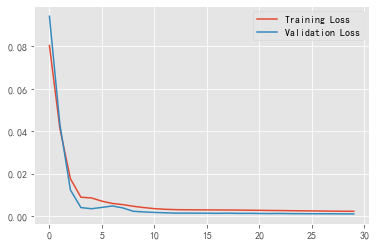

In [106]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
#plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [107]:
predicted_stock_price = model.predict(
    X_test)                        # 测试集输入模型进行预测
predicted_stock_price = sc.inverse_transform(
    predicted_stock_price)  # 对预测数据还原---从（0，1）反归一化到原始范围
real_stock_price = sc.inverse_transform(y_test)  # 对真实数据还原---从（0，1）反归一化到原始范围

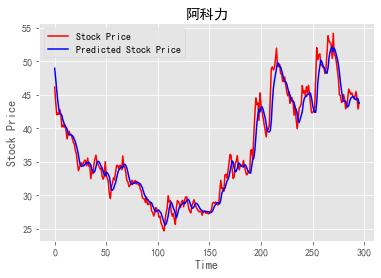

In [110]:
# 画出真实数据和预测数据的对比曲线
plt.plot(real_stock_price, color='red', label='Stock Price')
plt.plot(predicted_stock_price, color='blue', label='Predicted Stock Price')
plt.title('阿科力')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [109]:
MSE = metrics.mean_squared_error(predicted_stock_price, real_stock_price)
RMSE = metrics.mean_squared_error(predicted_stock_price, real_stock_price)**0.5
MAE = metrics.mean_absolute_error(predicted_stock_price, real_stock_price)
R2 = metrics.r2_score(predicted_stock_price, real_stock_price)

print('均方误差: %.5f' % MSE)
print('均方根误差: %.5f' % RMSE)
print('平均绝对误差: %.5f' % MAE)
print('R2: %.5f' % R2)

均方误差: 2.66646
均方根误差: 1.63293
平均绝对误差: 1.15204
R2: 0.95125
